cuda:0


ValueError: images do not match

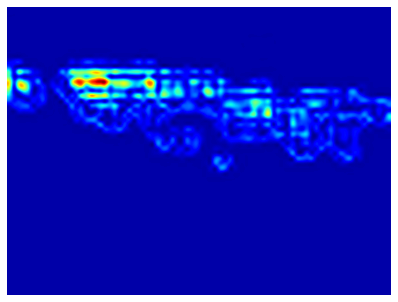

In [1]:

from random import random
import numpy as np
import torch,math,os 
from matplotlib import pyplot as plt 
from datasets.crowd import Crowd
from models.fusion_attr import fusion_model
import cv2
from PIL import Image
from show_pic import picshower
from torchvision import transforms
class Tool():
    
    def __init__(self) :
        self.device = torch.device("cuda:0") if(torch.cuda.is_available()) else torch.device("cpu")
    def __setattr__(self, __name: str, __value) -> None:
        super().__setattr__(__name,__value)
        if(__name == "device"):
            print(self.device)
        elif(__name == "model") :
            # save model structure
            with open("model_structure.txt", "a+") as f:
                f.write(str(__value))
        

    # 只对counting数据集有效
    def load(self,data_dir,model_dir,batch_size):

        datasets = Crowd(data_dir, method='test')
        self.dataloader = torch.utils.data.DataLoader(datasets, batch_size, shuffle=False,
                                             num_workers=2, pin_memory=True)
        self.model = fusion_model()
        self.model.load_state_dict(torch.load(model_dir,map_location = self.device))
        self.model.to(self.device)
        self.model.eval()
        self.data_dir = data_dir
        
    
    def value(self,model:torch.nn.Module,n:int,dataloader,device:torch.device) -> None:
        game = [0, 0, 0, 0]
        mse = [0, 0, 0, 0]
        total_relative_error = 0

        for i, [inputs, target, name] in enumerate(dataloader):
            
            if(i>=n): break;
            print(inputs.shape,target.shape)
            if type(inputs) == list:
                inputs[0] = inputs[0].to(device)
                inputs[1] = inputs[1].to(device)
            else:
                inputs = inputs.to(device)

            # inputs are images with different sizes
            if type(inputs) == list:
                assert inputs[0].size(0) == 1
            else:
                assert inputs.size(0) == 1, 'the batch size should equal to 1 in validation mode'
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                #------------------visual the outpt----------
                #self.softmax = torch.nn.Softmax(dim=1)

                #outputs_ =  self.softmax(outputs)
                #----------------------------------
                
                tgame,tmse = Tool.eval_game(outputs, target)
                game = [game[i]+tgame[i] for i in range(4)]
                mse = [mse[i]+tmse[i] for i in range(4)]
                relative_error = Tool.eval_relative(outputs, target)
                total_relative_error += relative_error
                
        N = min(len(dataloader),n)
        
        game = [m / N for m in game]
        mse = [torch.sqrt(m / N) for m in mse]
        total_relative_error = total_relative_error / N

        log_str = 'Test{}, GAME0 {game0:.2f} GAME1 {game1:.2f} GAME2 {game2:.2f} GAME3 {game3:.2f} ' \
                'MSE {mse:.2f} Re {relative:.4f}, '.\
            format(N, game0=game[0], game1=game[1], game2=game[2], game3=game[3], mse=mse[0], relative=total_relative_error)

        print(log_str)
    @classmethod
    def eval_game(self,output, target):
        output = output[0][0].cpu().numpy()
        target = target[0]
        H, W = target.shape
        ratio = H / output.shape[0] # usually 8
        output = cv2.resize(output, (W, H), interpolation=cv2.INTER_CUBIC) / (ratio*ratio) # reshape成H,W
        assert output.shape == target.shape
        game = [0,0,0,0]
        mse = [0,0,0,0]
        for L in range(4):
            p = pow(2, L)
            abs_error = 0
            square_error = 0
            for i in range(p):
                for j in range(p):
                    output_block = output[i*H//p:(i+1)*H//p, j*W//p:(j+1)*W//p]
                    target_block = target[i*H//p:(i+1)*H//p, j*W//p:(j+1)*W//p]

                    abs_error += abs(output_block.sum()-target_block.sum().float())
                    square_error += (output_block.sum()-target_block.sum().float()).pow(2)
            game[L] += abs_error
            mse[L] += square_error
        return game,mse
    # return : 保存图片的地址+resized output
    @classmethod
    def getTransform(self, model = "CUSTOM"):
        if model == "T":
            return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        elif model == "GRAY":
            return  transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
        elif model == "RGB":
            return  transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        elif isinstance(model,torch.nn.Module) or isinstance(model, transforms.Compose):
            return model
        else:
            raise NotImplementedError
    @classmethod # saveoutput
    def save_output(self,output,image_name = None,color = plt.cm.jet,save_path = "./",interplot = True,shape = None):
        if(interplot):
            assert shape is not None, "need a target"
            if(output.shape!=shape):
                ratio = shape[0]/output.shape[0]
                output = cv2.resize(output,(shape[1],shape[0]),interpolation=cv2.INTER_CUBIC)
        # 注意opencv的resize顺序是相反的
        
        plt.imshow(output,cmap=color)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        if image_name is None:
            image_name = str(random())
        save_prefix = os.path.join(save_path,image_name)
        plt.tight_layout(pad = 0)
        plt.savefig(save_prefix+".jpg")
        
        np.save(save_prefix,output/(ratio*ratio))
        
        return save_prefix+".jpg",output

    def test_named_images(self,namelist,gt,modellist,color = plt.cm.jet,save_path = "./", interplot = True, data_dir = None):
        if self.data_dir is None and data_dir is None:
            raise ValueError("data_dir is imexplicit")
        data_dir = data_dir if data_dir is not None else self.data_dir
        # get transform 
        # for custom ,you need to put your own model in the modellist


        input_trans = [self.getTransform(i) for i in modellist]
        inputs = []
        for i in range(len(input_trans)):
            img = cv2.imread(os.path.join(data_dir,namelist[i]))[..., ::-1].copy()
            img = input_trans[i](img)
            inputs.append(img)
        
        target = Tool.create_gt(inputs[0].shape[1:3],np.load(os.path.join(data_dir,gt)))
        target = torch.from_numpy(target.copy()).float()
        target.unsqueeze_(0)
        print(target.shape)
        output = self.model(inputs).squeeze_()

        print(output.shape)

    @classmethod
    def create_gt(self,shape, gt):
        k = np.zeros((shape[0], shape[1]))
        for i in range(0, len(gt)):
            if int(gt[i][1]) < shape[0] and int(gt[i][0]) < shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1
        return k
    @classmethod
    def easy_changename(self,name,model = "Cross"):
        if model == "Cross":
            return [name+"_RGB.jpg",name+"_T.jpg"],name+"_GT.npy",["RGB","T"]
        
    def test_random_image(self,color = plt.cm.jet,save_path = "./",blend = True, interplot = True,T = False):
        inputs,target, name = next(iter(self.dataloader))
        
        if type(inputs) == list:
            inputs[0] = inputs[0].to(self.device)
            inputs[1] = inputs[1].to(self.device)
            name = name[0]
        else:
            inputs = inputs.to(self.device)

        output = self.model(inputs).squeeze_()
        output = output.cpu().detach().numpy()
        # output [60,80]
        
        target.squeeze_()

        inputs[0].squeeze_()
        C,H,W = inputs[0].shape

        ratio = H/output.shape[0] # 8
        
        if T:
            input_path = os.path.join(self.data_dir,name)+"_T.jpg"
            
        else :
            input_path = os.path.join(self.data_dir,name)+"_RGB.jpg"
        #input_pic = cv2.imread(input_path)
        pic_path,output = Tool.save_output(output,image_name=name,color=color,save_path=save_path,interplot= interplot,shape = (H,W))
        
        if(blend):
            #Tool.npimg_blend(cv2.imread(pic_path), input_pic,save_name = "1.jpg", alpha = 0.5)
            Tool.pilimg_blend(Image.open(pic_path),Image.open(
                input_path
            ),"1.jpg",0.5)
        
        # target : 480*640
        return target.cpu().numpy(),output/(ratio*ratio),input_path,pic_path
    

        # TODO :增加一个60*80的
    @classmethod
    def fig2ndarray(self,fig)->np.ndarray:
        fig.canvas.draw()
        w,h = fig.canvas.get_width_height()
        buf_ndarray =  np.frombuffer(fig.canvas.tostring_rgb(),dtype="u1")
        im = buf_ndarray.reshape(h,w,3)
        return im
    @classmethod 
    def fig2pilimg(self,fig)->Image.Image:
        fig.canvas.draw()
        w,h = fig.canvas.get_width_height()
        
        im =Image.frombytes('RGB',(w,h),fig.canvas.tostring_rgb())
        return im
    @classmethod
    def ndarray2pilimg(self,fig)->Image.Image:
        return Image.fromarray((fig * 255).astype(np.uint8)).convert('RGB')
    @classmethod 
    def npimg_blend(self, img1, img2, save_name, alpha = 0.5):
        img1 = np.asarray(img1,np.float32)
        img2 = np.asarray(img2,np.float32)
        if(img1.shape != img2.shape):
            img1 = cv2.resize(img1,(img2.shape[1],img2.shape[0]),interpolation=cv2.INTER_CUBIC)
        res = cv2.addWeighted(img1,alpha,img2,1-alpha,0)
        cv2.imshow("blend",res)
        cv2.waitKey(0)
        cv2.imwrite(save_name,res)
    @classmethod     
    def pilimg_blend(self, img1:Image.Image, img2:Image.Image, save_name, alpha = 0.5):
        res =Image.blend(img1,img2,alpha)
        res.save(save_name)
    

    @classmethod
    def eval_relative(self,output:torch.Tensor, target:torch.Tensor):
        output_num = output.cpu().data.sum()
        target_num = target.sum().float()
        relative_error = abs(output_num-target_num)/target_num
        return relative_error
    @classmethod
    def add_anotation(self, gt, img):
        t = np.nonzero(gt)
        if(type(t) == tuple):
            for i in range(len(t[0])):
                cv2.circle(img,(t[1][i],t[0][i]),1,(0,0,255),4)
        else : return img # TODO
        return img
if(__name__ == "__main__"):
    t = Tool()
    t.load("C:\\Users\\17205\\1\\RGBT_process\\test","C:\\Users\\17205\\1\\best_model_drop05_47.pth",1)
    #t.value()
    #Tool.value(t.model,1,t.dataloader,t.device)
    # target,output,input_path,pic_path = t.test_random_image(blend=False)
    # s = picshower()
    # s.show_pic(target,output,Tool.add_anotation(target,img=cv2.imread(input_path)),cv2.imread(pic_path))
    #namelist,gt,mod = Tool.easy_changename("1206")
    #t.test_named_images(namelist,gt,mod)
    t.test_random_image()

In [5]:
a = next(iter(t.dataloader))

In [14]:
a[0][0].shape


torch.Size([1, 3, 480, 640])

cuda:0


c:\Users\17205\Anaconda3\lib\site-packages\torch\nn\functional.py:4058: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


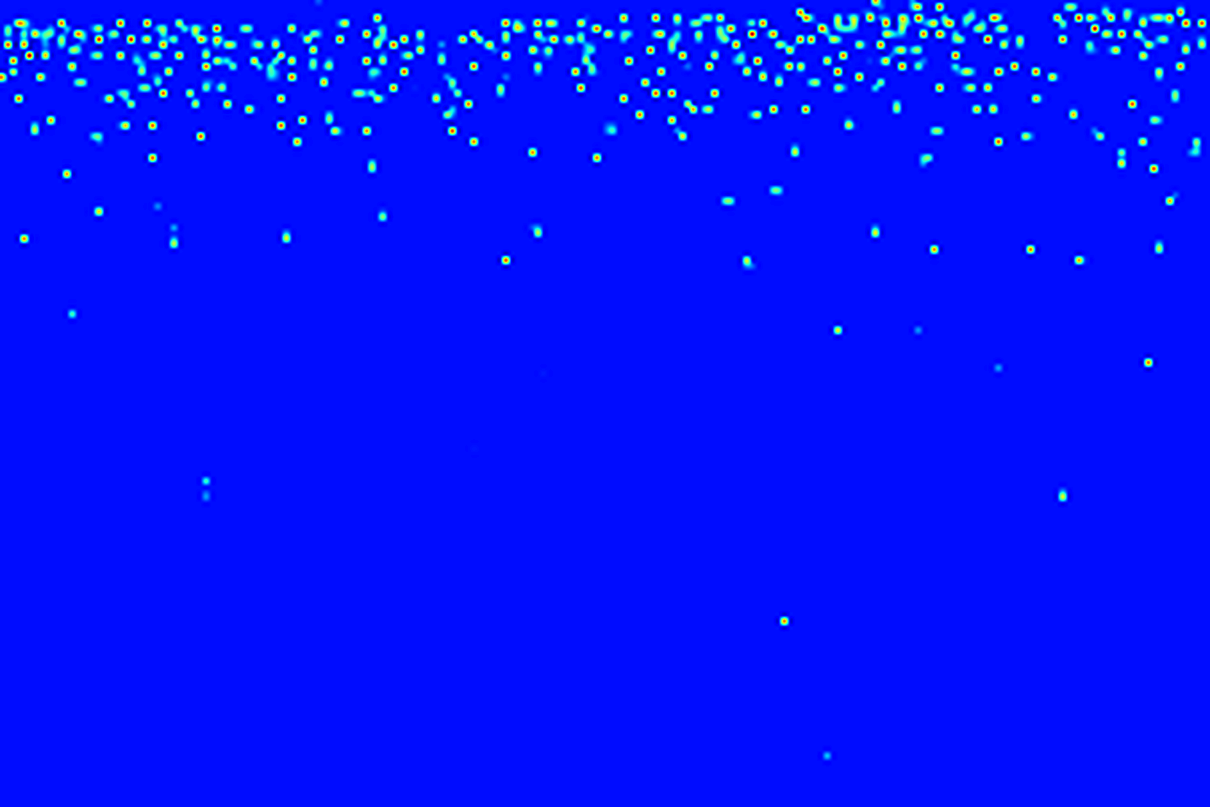

In [2]:

from random import random
import numpy as np
import torch,math,os 
from matplotlib import pyplot as plt 
from datasets.crowd import Crowd
from models.fusion_attr import FusionModel
from models.vgg import vgg19
import cv2
from PIL import Image
from show_pic import picshower
from torchvision import transforms
class Tool():
    
    def __init__(self) :
        self.device = torch.device("cuda:0") if(torch.cuda.is_available()) else torch.device("cpu")
    def __setattr__(self, __name: str, __value) -> None:
        super().__setattr__(__name,__value)
        if(__name == "device"):
            print(self.device)
        elif(__name == "model") :
            # save model structure
            with open("model_structure.txt", "a+") as f:
                f.write(str(__value))
        

    # 只对counting数据集有效
    def load(self,data_dir,model_dir,create_function,batch_size):

        datasets = Crowd(data_dir, method='test')
        self.dataloader = torch.utils.data.DataLoader(datasets, batch_size, shuffle=False,
                                             num_workers=2, pin_memory=True)
        self.model = create_function()
        if(model_dir.endswith("tar")):
            self.model.load_state_dict(torch.load(model_dir,map_location = self.device)['model_state_dict'])
        elif model_dir.endswith("pth"):
            self.model.load_state_dict(torch.load(model_dir,map_location = self.device))
        self.model.to(self.device)
        self.model.eval()
        self.data_dir = data_dir
        
    
    def value(self,model:torch.nn.Module,n:int,dataloader,device:torch.device) -> None:
        game = [0, 0, 0, 0]
        mse = [0, 0, 0, 0]
        total_relative_error = 0

        for i, [inputs, target, name] in enumerate(dataloader):
            
            if(i>=n): break;
            print(inputs.shape,target.shape)
            if type(inputs) == list:
                inputs[0] = inputs[0].to(device)
                inputs[1] = inputs[1].to(device)
            else:
                inputs = inputs.to(device)

            # inputs are images with different sizes
            if type(inputs) == list:
                assert inputs[0].size(0) == 1
            else:
                assert inputs.size(0) == 1, 'the batch size should equal to 1 in validation mode'
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                #------------------visual the outpt----------
                #self.softmax = torch.nn.Softmax(dim=1)

                #outputs_ =  self.softmax(outputs)
                #----------------------------------
                
                tgame,tmse = Tool.eval_game(outputs, target)
                game = [game[i]+tgame[i] for i in range(4)]
                mse = [mse[i]+tmse[i] for i in range(4)]
                relative_error = Tool.eval_relative(outputs, target)
                total_relative_error += relative_error
                
        N = min(len(dataloader),n)
        
        game = [m / N for m in game]
        mse = [torch.sqrt(m / N) for m in mse]
        total_relative_error = total_relative_error / N

        log_str = 'Test{}, GAME0 {game0:.2f} GAME1 {game1:.2f} GAME2 {game2:.2f} GAME3 {game3:.2f} ' \
                'MSE {mse:.2f} Re {relative:.4f}, '.\
            format(N, game0=game[0], game1=game[1], game2=game[2], game3=game[3], mse=mse[0], relative=total_relative_error)

        print(log_str)
    @classmethod
    def eval_game(self,output, target):
        output = output[0][0].cpu().numpy()
        target = target[0]
        H, W = target.shape
        ratio = H / output.shape[0] # usually 8
        output = cv2.resize(output, (W, H), interpolation=cv2.INTER_CUBIC) / (ratio*ratio) # reshape成H,W
        assert output.shape == target.shape
        game = [0,0,0,0]
        mse = [0,0,0,0]
        for L in range(4):
            p = pow(2, L)
            abs_error = 0
            square_error = 0
            for i in range(p):
                for j in range(p):
                    output_block = output[i*H//p:(i+1)*H//p, j*W//p:(j+1)*W//p]
                    target_block = target[i*H//p:(i+1)*H//p, j*W//p:(j+1)*W//p]

                    abs_error += abs(output_block.sum()-target_block.sum().float())
                    square_error += (output_block.sum()-target_block.sum().float()).pow(2)
            game[L] += abs_error
            mse[L] += square_error
        return game,mse
    # return : 保存图片的地址+resized output
    @classmethod
    def getTransform(self, model = "CUSTOM"):
        if model == "T":
            return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.492, 0.168, 0.430],
                std=[0.317, 0.174, 0.191]),
        ])
        elif model == "GRAY":
            return  transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
        elif model == "RGB":
            return  transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        elif isinstance(model,torch.nn.Module) or isinstance(model, transforms.Compose):
            return model
        else:
            raise NotImplementedError
    @classmethod # saveoutput
    def save_output(self,output,save_name = None,color = plt.cm.jet,save_path = "./",interplot = True,shape = None):
        if(interplot):
            assert shape is not None, "need a target"
            if(output.shape!=shape):
                ratio = shape[0]/output.shape[0]
                output = cv2.resize(output,(shape[1],shape[0]),interpolation=cv2.INTER_CUBIC)
        # 注意opencv的resize顺序是相反的
        # plt figshape?
        plt.figure(dpi = 1, figsize=shape) 
        plt.imshow(output,cmap=color)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        if save_name is None:
            save_name = str(random())
        save_prefix = os.path.join(save_path,save_name)
        plt.tight_layout(pad = 0)
        plt.savefig(save_prefix+".jpg")
        
        np.save(save_prefix,output/(ratio*ratio))
        
        return save_prefix+".jpg",output

    def test_named_images(self,namelist,gt,modellist,color = plt.cm.jet,save_path = "./", interplot = True, 
    data_dir = None, blend = False,save_name = "blend.jpg", pic_to_blend = 0):
        if self.data_dir is None and data_dir is None:
            raise ValueError("data_dir is imexplicit")
        data_dir = data_dir if data_dir is not None else self.data_dir
        # get transform 
        # for custom ,you need to put your own model in the modellist
        assert len(namelist) == len(modellist)

        input_trans = [self.getTransform(i) for i in modellist]
        inputs = []
        
        for i in range(len(input_trans)):
            img = cv2.imread(os.path.join(data_dir,namelist[i]))[..., ::-1].copy()
            shape = img.shape[:-1]
            
            img = input_trans[i](img)
            img = img.to(self.device)
            img.unsqueeze_(0)
            inputs.append(img)
        if(len(inputs) == 1):
            inputs = inputs[0]
        
        output = self.model(inputs).squeeze_()
        output = output.cpu().detach().numpy()

        target = Tool.create_gt(shape,np.load(os.path.join(data_dir,gt)))

        H,W = shape
        ratio = H/output.shape[0] # 8
        pic_path,output = Tool.save_output(output,color=color,save_path=save_path,interplot= interplot,shape = (H,W),save_name="saved_output")
        input_path = os.path.join(data_dir,namelist[pic_to_blend])
        if(blend):
            
        #input_pic = cv2.imread(input_path)
        
            #Tool.npimg_blend(cv2.imread(pic_path), input_pic,save_name = "1.jpg", alpha = 0.5)
            Tool.pilimg_blend(Image.open(pic_path),Image.open(
                input_path
            ),save_name,0.5)
        
        # target : 480*640
        return target,output/(ratio*ratio),input_path,pic_path
    @classmethod
    def create_gt(self,shape, gt):
        k = np.zeros((shape[0], shape[1]))
        for i in range(0, len(gt)):
            if int(gt[i][1]) < shape[0] and int(gt[i][0]) < shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1
        return k
    @classmethod
    def easy_changename(self,name,model = "Cross"):
        if model == "Cross":
            return [name+"_RGB.jpg",name+"_T.jpg"],name+"_GT.npy",["RGB","T"]
        if model == "UCF":
            return ["img_"+name.zfill(4)+".jpg"],"img_"+name.zfill(4)+".npy",["RGB"]
    def test_random_image(self,color = plt.cm.jet,save_path = "./",blend = True, interplot = True,T = False):
        inputs,target, name = next(iter(self.dataloader))
        
        if type(inputs) == list:
            inputs[0] = inputs[0].to(self.device)
            inputs[1] = inputs[1].to(self.device)
            name = name[0]
        else:
            inputs = inputs.to(self.device)

        output = self.model(inputs).squeeze_()
        output = output.cpu().detach().numpy()
        # output [60,80]
        
        target.squeeze_()

        inputs[0].squeeze_()
        C,H,W = inputs[0].shape

        ratio = H/output.shape[0] # 8
        
        if T:
            input_path = os.path.join(self.data_dir,name)+"_T.jpg"
            
        else :
            input_path = os.path.join(self.data_dir,name)+"_RGB.jpg"
        #input_pic = cv2.imread(input_path)
        pic_path,output = Tool.save_output(output,image_name=name,color=color,save_path=save_path,interplot= interplot,shape = (H,W))
        
        if(blend):
            #Tool.npimg_blend(cv2.imread(pic_path), input_pic,save_name = "1.jpg", alpha = 0.5)
            Tool.pilimg_blend(Image.open(pic_path),Image.open(
                input_path
            ),"1.jpg",0.5)
        
        # target : 480*640
        return target.cpu().numpy(),output/(ratio*ratio),input_path,pic_path
    

        # TODO :增加一个60*80的
    @classmethod
    def fig2ndarray(self,fig)->np.ndarray:
        fig.canvas.draw()
        w,h = fig.canvas.get_width_height()
        buf_ndarray =  np.frombuffer(fig.canvas.tostring_rgb(),dtype="u1")
        im = buf_ndarray.reshape(h,w,3)
        return im
    @classmethod 
    def fig2pilimg(self,fig)->Image.Image:
        fig.canvas.draw()
        w,h = fig.canvas.get_width_height()
        
        im =Image.frombytes('RGB',(w,h),fig.canvas.tostring_rgb())
        return im
    @classmethod
    def ndarray2pilimg(self,fig)->Image.Image:
        return Image.fromarray((fig * 255).astype(np.uint8)).convert('RGB')
    @classmethod 
    def npimg_blend(self, img1, img2, save_name, alpha = 0.5):
        img1 = np.asarray(img1,np.float32)
        img2 = np.asarray(img2,np.float32)
        if(img1.shape != img2.shape):
            img1 = cv2.resize(img1,(img2.shape[1],img2.shape[0]),interpolation=cv2.INTER_CUBIC)
        res = cv2.addWeighted(img1,alpha,img2,1-alpha,0)
        cv2.imshow("blend",res)
        cv2.waitKey(0)
        cv2.imwrite(save_name,res)
    @classmethod     
    def pilimg_blend(self, img1:Image.Image, img2:Image.Image, save_name, alpha = 0.5):
        res =Image.blend(img1,img2,alpha)
        res.save(save_name)
    

    @classmethod
    def eval_relative(self,output:torch.Tensor, target:torch.Tensor):
        output_num = output.cpu().data.sum()
        target_num = target.sum().float()
        relative_error = abs(output_num-target_num)/target_num
        return relative_error
    @classmethod
    def add_anotation(self, gt, img):
        t = np.nonzero(gt)
        if(type(t) == tuple):
            for i in range(len(t[0])):
                cv2.circle(img,(t[1][i],t[0][i]),1,(0,0,255),4)
        else : return img # TODO
        return img
if(__name__ == "__main__"):
    t = Tool()
    #t.load("C:\\Users\\17205\\1\\RGBT_process\\test","C:\\Users\\17205\\1\\999_ckpt.tar",FusionModel,1)
    #t.load('/home/home/qinnan/dataset/UCF-Train-Val-Test/test','/home/home/qinnan/counting/Bayesian-Crowd-Counting/model/1019-215043/999_ckpt.tar',vgg19,1)
    t.load("D:\\2022\\datasets\\UCF-Train-Val-Test\\test","C:\\Users\\17205\\1\\999_ckpt.tar",vgg19,1)
    #t.value()
    #Tool.value(t.model,1,t.dataloader,t.device)
    # target,output,input_path,pic_path = t.test_random_image(blend=False)
    # s = picshower()
    # s.show_pic(target,output,Tool.add_anotation(target,img=cv2.imread(input_path)),cv2.imread(pic_path))
    namelist,gt,mod = Tool.easy_changename("30",model = "UCF")
    target,output,input_path,pic_path = t.test_named_images(namelist,gt,mod)
    s = picshower()
   # s.show_pic(target,output,[Tool.add_anotation(target,img=cv2.imread(input_path)),cv2.imread(pic_path)])


In [3]:
s = picshower()
s.show_pic(target,output,[Tool.add_anotation(target,img=cv2.imread(input_path)),cv2.imread(pic_path)])

TypeError: show_pic() takes 4 positional arguments but 5 were given

In [1]:

cv2.imread()

NameError: name 'cv2' is not defined